# How to train your own word vector embeddings with Keras

Many tasks require embeddings or domain-specific vocabulary that pre-trained models based on a generic corpus may not represent well or at all. Standard word2vec models are not able to assign vectors to out-of-vocabulary words and instead use a default vector that reduces their predictive value.

E.g., when working with industry-specific documents, the vocabulary or its usage may change over time as new technologies or products emerge. As a result, the embeddings need to evolve as well. In addition, corporate earnings releases use nuanced language not fully reflected in Glove vectors pre-trained on Wikipedia articles.

We will illustrate the word2vec architecture using the keras library that we will introduce in more detail in the next chapter and the more performant gensim adaptation of the code provided by the word2vec authors. 

To illustrate the word2vec network architecture, we use the Financial News data that we first introduced in chapter 14 on Topic Modeling. 

## Imports

If you have not yet installed `TensorFlow 2`, uncomment and run one of the following, the first if you have a GPU and the second otherwise. Alternatively, run this notebook using the environment `ml4t-dl`.

In [1]:
# !conda install -n ml4t tensorflow-gpu -y

In [2]:
#!conda install -n ml4t tensorflow -y

In [3]:
%matplotlib inline

from pathlib import Path
from collections import Counter

import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Reshape, Dot, Embedding
from tensorflow.keras.preprocessing.sequence import skipgrams, make_sampling_table
from tensorflow.keras.callbacks import Callback, TensorBoard

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

### Settings

In [5]:
sns.set_style('white')
np.random.seed(42)

### Paths

In [6]:
results_path = Path('results', 'financial_news')

In [7]:
analogy_path = Path('data', 'analogies-en.txt')

In [8]:
def format_time(t):
    m, s = divmod(t, 60)
    h, m = divmod(m, 60)
    return f'{h:02.0f}:{m:02.0f}:{s:02.0f}'

## `word2vec` - skipgram Architecture using Keras

### Settings

In [9]:
LANGUAGE = 'en'
SAMPLE_SIZE=.5              # portion of sentences to use for model
NGRAMS = 3                  # Longest ngram in text
MIN_FREQ = 10

In [10]:
SAMPLING_FACTOR = 1e-4
WINDOW_SIZE = 3
EMBEDDING_SIZE = 300
EPOCHS = 1
BATCH_SIZE = 2500

In [11]:
# Set up validation
VALID_SET = 10      # Random set of words to get nearest neighbors for
VALID_WINDOW = 150  # Most frequent words to draw validation set from
NN = 10             # Number of nearest neighbors for evaluation

valid_examples = np.random.choice(VALID_WINDOW, size=VALID_SET, replace=False)

In [12]:
FILE_NAME = f'articles_{NGRAMS}_grams.txt'
file_path = results_path / FILE_NAME

In [13]:
tb_path = results_path / 'tensorboard'
if not tb_path.exists():
    tb_path.mkdir(parents=True, exist_ok=True)

### Build Data Set

#### Tokens to ID

1. Extract the top *n* most common words to learn embeddings
2. Index these *n* words with unique integers
3. Create an `{index: word}` dictionary
4. Replace the *n* words with their index, and a dummy value `UNK` elsewhere

In [14]:
sentences = file_path.read_text().split('\n')
n = len(sentences)

In [15]:
max_length = 50

In [16]:
sentences = [s for s in sentences if len(s.split()) <= max_length]

In [17]:
print(f'Removed {n-len(sentences):,.0f} sentences containing more than {max_length} tokens')

Removed 59,438 sentences containing more than 50 tokens


In [18]:
words = ' '.join(np.random.choice(sentences, size=int(.5*len(sentences)), replace=False)).split()

In [19]:
# Get (token, count) tuples for tokens meeting MIN_FREQ
token_counts = [t for t in Counter(words).most_common() if t[1] >= MIN_FREQ]
tokens, counts = list(zip(*token_counts))

# create id-token dicts & reverse dicts
id_to_token = pd.Series(tokens, index=range(1, len(tokens) + 1)).to_dict()
id_to_token.update({0: 'UNK'})
token_to_id = {t: i for i, t in id_to_token.items()}
data = [token_to_id.get(word, 0) for word in words]

In [20]:
vocab_size = len(token_to_id)

In [21]:
vocab_size

60545

In [22]:
s = pd.Series(data).value_counts().reset_index()
s.columns = ['id', 'count']
s['token'] = s.id.map(id_to_token)

In [23]:
s.sort_values('count', ascending=False).head(10)

,id,count,token
0,0,422022,UNK
1,1,173807,company
2,2,171384,million
3,3,150168,said
4,4,113295,year
5,5,108431,quarter
6,6,83870,financial
7,7,79069,reuters
8,8,75674,percent
9,9,75324,net


In [24]:
s['count'].sum()

17985158

In [25]:
s.sort_values('id').token.dropna().to_csv(tb_path / 'meta.tsv', index=False)

#### Analogies to ID

In [26]:
def get_analogies():
    df = pd.read_csv(analogy_path, header=None, squeeze=True)
    categories = df[df.str.startswith(':')]
    analogies = df[~df.str.startswith(':')].str.split(expand=True)
    analogies.columns = list('abcd')
    return analogies

In [27]:
analogies = get_analogies()
analogies.head()

,a,b,c,d
1,athens,greece,baghdad,iraq
2,athens,greece,bangkok,thailand
3,athens,greece,beijing,china
4,athens,greece,berlin,germany
5,athens,greece,bern,switzerland


In [28]:
analogies_id = analogies.apply(lambda x: x.map(token_to_id))
analogies_id.notnull().all(1).sum()/len(analogies_id)

0.7297574039067423

### Generate Sampling Probabilities

There is an alternative, faster scheme than the traditional SoftMax loss function called [Noise Contrastive Estimation (NCE)](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf).

Instead of getting the softmax probability for all possible context words, randomly sample 2-20 possible context words and evaluate the probability only for these.

**SAMPLING_FACTOR**: used for generating the `sampling_table` argument for `skipgrams`. 

`sampling_table[i]` is the probability of sampling the word i-th most common word in a dataset

The sampling probabilities are generated according
to the sampling distribution used in word2vec:

$p(\text{word}) = \min\left(1, \frac{\sqrt{\frac{\text{word frequency}}{\text{sampling factor}}}}{\frac{\text{word frequency}}{\text{sampling factor}}}\right)$

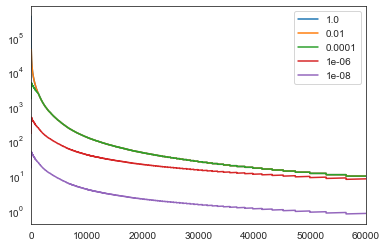

In [29]:
df = s['count'].to_frame('freq')
factors = [1, 1e-2, 1e-4, 1e-6, 1e-8]
for f in factors:
    sf = make_sampling_table(vocab_size, sampling_factor=f)
    df[f] = df.freq.mul(sf)
df.loc[:, factors].plot(logy=True, xlim=(0, 60000));

In [30]:
sampling_table = make_sampling_table(vocab_size, sampling_factor=SAMPLING_FACTOR/10)

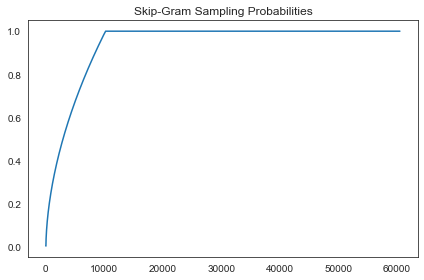

In [31]:
pd.Series(sampling_table).plot(title='Skip-Gram Sampling Probabilities')
plt.tight_layout();

### Generate target-context word pairs

In [32]:
pairs, labels = skipgrams(sequence=data,
                          vocabulary_size=vocab_size,
                          window_size=WINDOW_SIZE,
                          sampling_table=sampling_table,
                          negative_samples=1.0,
                          shuffle=True)

print('{:,d} pairs created'.format(len(pairs)))

64,510,238 pairs created


In [33]:
target_word, context_word = np.array(pairs, dtype=np.int32).T
labels = np.array(labels, dtype=np.int8)
del pairs

In [34]:
target_word[:5]

array([ 6581,  1030, 13977,  5859,  7566], dtype=int32)

In [35]:
df = pd.DataFrame({'target': target_word[:5], 
                   'context': context_word[:5], 
                   'label': labels[:5]})
df

,target,context,label
0,6581,244,1
1,1030,55576,0
2,13977,757,1
3,5859,1736,1
4,7566,8,1


In [36]:
pd.Series(labels).value_counts()

1    32255119
0    32255119
dtype: int64

In [37]:
with pd.HDFStore(results_path / 'data.h5') as store:
    store.put('id_to_token', pd.Series(id_to_token))
    store.put('pairs', pd.DataFrame({'target' : target_word,
                                     'context': context_word, 
                                     'labels': labels}))

In [38]:
with pd.HDFStore(results_path / 'data.h5') as store:
    id_to_token = store['id_to_token']
    pairs = store['pairs']
target_word, context_word, labels = pairs.target, pairs.context, pairs.labels

### Define Keras Model Components

#### Scalar Input Variables

In [39]:
input_target = Input((1,), name='target_input')
input_context = Input((1,), name='context_input')

#### Shared Embedding Layer

In [40]:
embedding = Embedding(input_dim=vocab_size,
                      output_dim=EMBEDDING_SIZE,
                      input_length=1,
                      name='embedding_layer')

In [41]:
target = embedding(input_target)
target = Reshape((EMBEDDING_SIZE, 1), name='target_embedding')(target)

context = embedding(input_context)
context = Reshape((EMBEDDING_SIZE, 1), name='context_embedding')(context)

#### Create Similarity Measure

In [42]:
dot_product = Dot(axes=1)([target, context])
dot_product = Reshape((1,), name='similarity')(dot_product)

#### Sigmoid Output Layer

In [43]:
output = Dense(units=1, activation='sigmoid', name='output')(dot_product)

#### Compile Training Model

In [44]:
model = Model(inputs=[input_target, input_context], outputs=output)
model.compile(loss='binary_crossentropy', optimizer='rmsprop')

#### Display Architecture

In [45]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
target_input (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
context_input (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_layer (Embedding)     (None, 1, 300)       18163500    target_input[0][0]               
                                                                 context_input[0][0]              
__________________________________________________________________________________________________
target_embedding (Reshape)      (None, 300, 1)       0           embedding_layer[0][0]        

#### Validation Model

In [46]:
similarity = Dot(normalize=True, 
                 axes=1, 
                 name='cosine_similarity')([target, context])

In [47]:
# create a secondary validation model to run our similarity checks during training
validation_model = Model(inputs=[input_target, input_context], outputs=similarity)

In [48]:
validation_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
target_input (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
context_input (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_layer (Embedding)     (None, 1, 300)       18163500    target_input[0][0]               
                                                                 context_input[0][0]              
__________________________________________________________________________________________________
target_embedding (Reshape)      (None, 300, 1)       0           embedding_layer[0][0]      

![Keras Graph](https://s3.amazonaws.com/applied-ai/images/keras_graph_tensorboard.png)

### Create Keras Callbacks

####  Nearest Neighors & Analogies

In [49]:
test_set = analogies_id.dropna().astype(int)
a, b, c, actual = test_set.values.T
actual = actual.reshape(-1, 1)
n_analogies = len(actual)

In [50]:
class EvalCallback(Callback):
        
    def on_train_begin(self, logs={}):
        self.eval_nn()
        self.test_analogies()

    def on_train_end(self, logs={}):
        self.eval_nn()

    def on_epoch_end(self, batch, logs={}):
        self.test_analogies()

    @staticmethod
    def test_analogies():
        print('\nAnalogy Accuracy:\n\t', end='')
        embeddings = embedding.get_weights()[0]
        target = embeddings[c] + embeddings[b] - embeddings[a]
        neighbors = np.argsort(cdist(target, embeddings, metric='cosine'))
        match_id = np.argwhere(neighbors == actual)[:, 1]
        print('\n\t'.join(['Top {}: {:.2%}'.format(i, (match_id < i).sum() / n_analogies) for i in [1, 5, 10]]))

    def eval_nn(self):
        print('\n{} Nearest Neighbors:'.format(NN))
        for i in range(VALID_SET):
            valid_id = valid_examples[i]
            valid_word = id_to_token[valid_id]
            similarity = self._get_similiarity(valid_id).reshape(-1)
            nearest = (-similarity).argsort()[1:NN + 1]
            neighbors = [id_to_token[nearest[n]] for n in range(NN)]
            print('{}:\t{}'.format(valid_word, ', '.join(neighbors)))            
        
    @staticmethod
    def _get_similiarity(valid_word_idx):
        target = np.full(shape=vocab_size, fill_value=valid_word_idx)
        context = np.arange(vocab_size)
        return validation_model.predict([target, context])


evaluation = EvalCallback()

#### Tensorboard Callback

Currently tensorflow has a [bug](https://github.com/tensorflow/tensorflow/issues/32902) that prevents metadata from working. The GitHub issue points to a simple fix that you can apply to the tensorflow source code, just search for the culprit line and change accordingly until a later release remedies this problem. You will have to install with `pip` for this purpose.

In [51]:
tensorboard = TensorBoard(log_dir=str(tb_path),
                          write_graph=True,
                          embeddings_freq=1,
                          embeddings_metadata={'embedding_layer': 
                                               str(tb_path / 'meta.tsv')})

### Train Model

In [53]:
loss = model.fit(x=[target_word, context_word],
                 y=labels,
                 shuffle=True,
                 batch_size=BATCH_SIZE,
                 epochs=EPOCHS,
#                  callbacks=[evaluation, tensorboard] # uncomment if tensorboard bug is fixed
                 callbacks=[evaluation]
                )


10 Nearest Neighbors:
products:	lauda, logo_pictured_pasadena_california, confluence, prevails, waltz, boca, stk, amerco, revolutionary_guard, appeals_court_upheld
share:	rampant_corruption, uncorrelated, databases, separations, programmatic_advertising, prg, causes, purcari, stifling, glaring
website:	binding_letter_intent, cherokee, amami_oshima, sprung, confirmed, barriers_entry, sanctions, replies, airtel, experience_litigating
ebitda:	refile, trillion_cubic_feet, sex_daniels, danger, morris_plains, volvo_trucks, duncan, nidaa_tounes, collars, rotating_presidency
the:	petrofac, chronic_constipation, barnard, failed_putsch, trillium, iata, narrow_browser_and, vacations, rubbermaid, shulman
president:	henkel, unanimous, erectile_dysfunction, rank, irri_al_tal, energetic, arithmetic, seems, spigot, perceived
investors:	favourable_variance, interacting, schulte, loomed, logility, lack_clarity, solid, simon_robinson, confirmation, antibiotic_resistance
long:	vegetables, america_movil, 

In [55]:
model.save(str(results_path / 'skipgram_model.h5'))

### Visualize Embeddings using Tensorboard

Load the embeddings metadata using the `load` option to view embedding labels and see [tutorial](https://www.tensorflow.org/tensorboard/get_started) for usage instructions.

In [56]:
%load_ext tensorboard

In [57]:
%tensorboard --logdir results/financial_news/tensorboard/train

## Resources

- [Distributed representations of words and phrases and their compositionality](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)
- [Efficient estimation of word representations in vector space](https://arxiv.org/pdf/1301.3781.pdf?)
- [Sebastian Ruder's Blog](http://ruder.io/word-embeddings-1/)